In [1]:
import collections
import os
import typing

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_federated as tff

In [2]:
# required to run TFF inside Jupyter notebooks
import nest_asyncio
nest_asyncio.apply()

In this tutorial we will use the classic MNIST dataset to introduce the Federated Learning (FL) API layer of TFF, [`tff.learning`](https://www.tensorflow.org/federated/api_docs/python/tff/learning) - a set of high-level interfaces that can be used to perform common types of federated learning tasks, such as federated training, against user-supplied models implemented in TensorFlow or Keras.

In [3]:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

# Preparing the data

TODO: Define the difference between IID and non-IID data.

With IID data federated learning doesn't seem any different than standard distributed training.
Discuss Horovod example.

Federated learning requires a federated data set, i.e., a collection of data from multiple users. Federated data is typically non-i.i.d., which poses a unique set of challenges.

In order to facilitate experimentation TFF includes federated versions of several populare datasets, including a federated version of MNIST that contains a version of the original NIST dataset that has been re-processed using Leaf so that the data is keyed by the original writer of the digits. Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

In [68]:
# What datasets are available?
tff.simulation.datasets.

In [3]:
tff.simulation.datasets.emnist.load_data?

Signature: tff.simulation.datasets.emnist.load_data(only_digits=True, cache_dir=None)
Docstring:
Loads the Federated EMNIST dataset.

Downloads and caches the dataset locally. If previously downloaded, tries to
load the dataset from cache.

This dataset is derived from the Leaf repository
(https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
dataset, grouping examples by writer. Details about Leaf were published in
"LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.

*Note*: This dataset does not include some additional preprocessing that
MNIST includes, such as size-normalization and centering.
In the Federated EMNIST data, the value of 1.0
corresponds to the background, and 0.0 corresponds to the color of the digits
themselves; this is the *inverse* of some MNIST representations,
e.g. in [tensorflow_datasets]
(https://github.com/tensorflow/datasets/blob/master/docs/datasets.md#mnist),
where 0 corresponds to the background color, and 255 

In [4]:
emnist_train, emnist_test = (tff.simulation
                                .datasets
                                .emnist
                                .load_data(only_digits=True, cache_dir="../data"))


/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [5]:
NUMBER_CLIENTS = len(emnist_train.client_ids)
NUMBER_CLIENTS

3383

In [6]:
def sample_client_ids(client_ids: typing.List[str],
                      sample_size: typing.Union[float, int],
                      random_state: np.random.RandomState) -> typing.List[str]:
    """Randomly selects a subset of clients ids."""
    number_clients = len(client_ids)
    error_msg = "'client_ids' must be non-emtpy."
    assert number_clients > 0, error_msg
    if isinstance(sample_size, float):
        error_msg = "Sample size must be between 0 and 1."
        assert 0 <= sample_size <= 1, error_msg
        size = int(sample_size * number_clients)
    elif isinstance(sample_size, int):
        error_msg = f"Sample size must be between 0 and {number_clients}."
        assert 0 <= sample_size <= number_clients, error_msg
        size = sample_size
    else:
        error_msg = "Type of 'sample_size' must be 'float' or 'int'."
        raise TypeError(error_msg)
    random_idxs = random_state.randint(number_clients, size=size)
    return [client_ids[i] for i in random_idxs]


In [7]:
# these are what the client ids look like
_random_state = np.random.RandomState(42)
sample_client_ids(emnist_train.client_ids, 10, _random_state)

['f3891_31',
 'f1059_15',
 'f1496_39',
 'f1332_24',
 'f1297_30',
 'f3809_17',
 'f1846_45',
 'f2385_83',
 'f0663_30',
 'f1440_10']

In [8]:
def create_client_datasets(source: tff.simulation.ClientData,
                           client_ids: typing.List[str]) -> typing.Dict[str, tf.data.Dataset]:
    datasets = {client_id: source.create_tf_dataset_for_client(client_id) for client_id in client_ids}
    return datasets


def sample_client_datasets(source: tff.simulation.ClientData,
                           sample_size: typing.Union[float, int],
                           random_state: np.random.RandomState) -> typing.List[tf.data.Dataset]:
    """Randomly selects a subset of client datasets."""
    client_ids = sample_client_ids(source.client_ids, sample_size, random_state)
    client_datasets = create_client_datasets(source, client_ids)
    return client_datasets


In [9]:
_random_state = np.random.RandomState(42)
client_datasets = sample_client_datasets(emnist_train, sample_size=1, random_state=_random_state)

In [10]:
# here is TensorFlow Dataset for a particular client
(client_id, client_dataset), *_ = client_datasets.items()

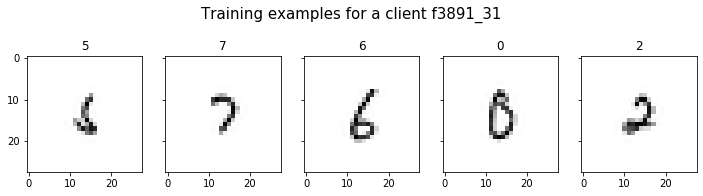

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(12,6), sharex=True, sharey=True)
for i, example in enumerate(client_dataset.take(5)):
    axes[i].imshow(example["pixels"].numpy(), cmap="gray")
    axes[i].set_title(example["label"].numpy())
_ = fig.suptitle(x= 0.5, y=0.75, t=f"Training examples for a client {client_id}", fontsize=15)   


Feature distribution skew(covariate shift): The marginal distributionsPi(x)may vary across clients,even ifP(y|x)is shared.4For example, in a handwriting recognition domain, users who write thesame words might still have different stroke width, slant, etc.

## Data preprocessing

Since each client dataset is already a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), preprocessing can be accomplished using Dataset transformations. Another option would be to use preprocessing operations from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html).

Preprocessing consists of the following steps:

1. `map` a function that flattens the 28 x 28 images into 784-element tensors
2. `map` a function that rename the features from pixels and label to X and y for use with Keras
3. `shuffle` the individual examples
4. `batch` the into training batches

We also throw in a `repeat` over the data set to run several epochs on each client device before sending parameters to the server for averaging.

In [12]:
AUTOTUNE = (tf.data
              .experimental
              .AUTOTUNE)
SHUFFLE_BUFFER_SIZE = 500
NUMBER_TRAINING_EPOCHS = 1 # number of local updates!
TRAINING_BATCH_SIZE = 32
TESTING_BATCH_SIZE = 32

NUMBER_FEATURES = 28 * 28
NUMBER_TARGETS = 10

In [13]:
def _reshape(training_batch):
    """Extracts and reshapes data from a training sample """
    pixels = training_batch["pixels"]
    label = training_batch["label"]
    X = tf.reshape(pixels, shape=[-1]) # flattens 2D pixels to 1D
    y = tf.reshape(label, shape=[1])
    return X, y


def create_training_dataset(client_dataset: tf.data.Dataset,
                            seed: typing.Union[None, int] = None,
                            shuffle_buffer_size: int = SHUFFLE_BUFFER_SIZE,
                            number_epochs: int = NUMBER_TRAINING_EPOCHS,
                            batch_size: int = TRAINING_BATCH_SIZE) -> tf.data.Dataset:
    """Create a training dataset for a client from a raw client dataset."""
    training_dataset = (client_dataset.map(_reshape, num_parallel_calls=AUTOTUNE)
                                      .shuffle(shuffle_buffer_size, seed, reshuffle_each_iteration=True)
                                      .repeat(number_epochs)
                                      .batch(batch_size)
                                      .prefetch(buffer_size=AUTOTUNE))
    return training_dataset


def create_testing_dataset(client_dataset: tf.data.Dataset,
                           batch_size: int = TESTING_BATCH_SIZE) -> tf.data.Dataset:
    """Create a testing dataset for a client from a raw client dataset."""
    testing_dataset = (client_dataset.map(_reshape, num_parallel_calls=AUTOTUNE)
                                     .batch(batch_size))
    return testing_dataset


## How to choose the clients included in each training round

In a typical federated training scenario there will be a very large population of user devices however only a fraction of these devices are likely to be available for training at a given point in time. For example, if the client devices are mobile phones then they might only participate in training when plugged into a power source, off a metered network, and otherwise idle.

In a simulated environment, where all data is locally available, an approach is to simply sample a random subset of the clients to be involved in each round of training so that the subset of clients involved will vary from round to round.

### How many clients to include in each round?

Updating and averaging a larger number of client models per training round yields better convergence and in a simulated training environment probably makes sense to include as many clients as is computationally feasible. However in real-world training scenario while averaging a larger number of clients improve convergence, it also makes training vulnerable to slowdown due to unpredictable tail delays in computation/communication at/with the clients.

In [85]:
def create_federated_data(training_source: tff.simulation.ClientData,
                          testing_source: tff.simulation.ClientData,
                          sample_size: typing.Union[float, int],
                          random_state: np.random.RandomState) -> typing.Dict[str, typing.Tuple[tf.data.Dataset, tf.data.Dataset]]:
    # sample clients ids from the training dataset
    client_ids = sample_client_ids(training_source.client_ids, sample_size, random_state)
    
    federated_data = {}
    for client_id in client_ids:
        # create training dataset for the client
        _tf_dataset = training_source.create_tf_dataset_for_client(client_id)
        training_dataset = create_training_dataset(_tf_dataset)
        
        # create the testing dataset for the client
        _tf_dataset = testing_source.create_tf_dataset_for_client(client_id)
        testing_dataset = create_testing_dataset(_tf_dataset)
        
        federated_data[client_id] = (training_dataset, testing_dataset)
    
    return federated_data

In [86]:
_random_state = np.random.RandomState(42)
federated_data = create_federated_data(emnist_train,
                                       emnist_test,
                                       sample_size=0.01,
                                       random_state=_random_state)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [88]:
# keys are client ids, values are (training_dataset, testing_dataset) pairs
len(federated_training_data)

33

# Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras model. Since the model will need to be replicated on each of the client devices we wrap the model in a no-argument Python function, a representation of which, will eventually be invoked on each client to create the model on that client.

In [19]:
def create_keras_model_fn() -> keras.Model:
    model_fn = keras.models.Sequential([
      keras.layers.Input(shape=(NUMBER_FEATURES,)),
      keras.layers.Dense(units=NUMBER_TARGETS),
      keras.layers.Softmax(),
    ])
    return model_fn


In order to use any model with TFF, it needs to be wrapped in an instance of the [`tff.learning.Model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) interface, which exposes methods to stamp the model's forward pass, metadata properties, etc, and also introduces additional elements such as ways to control the process of computing federated metrics. 

Once you have a Keras model like the one we've just defined above, you can have TFF wrap it for you by invoking [`tff.learning.from_keras_model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/from_keras_model), passing the model and a sample data batch as arguments, as shown below.

In [42]:
tff.learning.from_keras_model?

Signature:
tff.learning.from_keras_model(
    keras_model,
    dummy_batch,
    loss,
    loss_weights=None,
    metrics=None,
    optimizer=None,
)
Docstring:
Builds a `tff.learning.Model` for an example mini batch.

Args:
  keras_model: A `tf.keras.Model` object that is not compiled.
  dummy_batch: A nested structure of values that are convertible to *batched*
    tensors with the same shapes and types as would be input to `keras_model`.
    The values of the tensors are not important and can be filled with any
    reasonable input value.
  loss: A callable that takes two batched tensor parameters, `y_true` and
    `y_pred`, and returns the loss. If the model has multiple outputs, you can
    use a different loss on each output by passing a dictionary or a list of
    losses. The loss value that will be minimized by the model will then be
    the sum of all individual losses, each weighted by `loss_weights`.
  loss_weights: (Optional) a list or dictionary specifying scalar coefficien

In [21]:
def create_tff_model_fn() -> tff.learning.Model:
    keras_model = create_keras_model_fn()
    dummy_batch = (tf.constant(0.0, shape=(TRAINING_BATCH_SIZE, NUMBER_FEATURES), dtype=tf.float32),
                   tf.constant(0, shape=(TRAINING_BATCH_SIZE, 1), dtype=tf.int32))
    loss_fn = (keras.losses
                    .SparseCategoricalCrossentropy())
    metrics = [
        keras.metrics.SparseCategoricalAccuracy()
    ]
    tff_model_fn = (tff.learning
                       .from_keras_model(keras_model, dummy_batch, loss_fn, None, metrics))
    return tff_model_fn


Again, since our model will need to be replicated on each of the client devices we wrap the model in a no-argument Python function, a representation of which, will eventually be invoked on each client to create the model on that client.

# Training the model on federated data

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we can let TFF construct a Federated Averaging algorithm by invoking the helper function `tff.learning.build_federated_averaging_process` as follows.

Keep in mind that the argument needs to be a constructor (such as `create_tff_model_fn` above), not an already-constructed instance, so that the construction of your model can happen in a context controlled by TFF.

One critical note on the Federated Averaging algorithm below, there are 2 optimizers: a 

1. `client_optimizer_fn` which is only used to compute local model updates on each client. 
2. `server_optimizer_fn` applies the averaged update to the global model on the server. 

N.B. the choice of optimizer and learning rate may need to be different than those you would use to train the model on a standard i.i.d. dataset. Start with stochastic gradient descent with a smaller (than normal) learning rate.

In [24]:
tff.learning.build_federated_averaging_process?

Signature:
tff.learning.build_federated_averaging_process(
    model_fn: Callable[[], tensorflow_federated.python.learning.model.Model],
    client_optimizer_fn: Union[Callable[[], tensorflow.python.keras.optimizer_v2.optimizer_v2.OptimizerV2], NoneType] = None,
    server_optimizer_fn: Callable[[], tensorflow.python.keras.optimizer_v2.optimizer_v2.OptimizerV2] = <function <lambda> at 0x1132e9ef0>,
    client_weight_fn: Callable[[Any], tensorflow.python.framework.ops.Tensor] = None,
    stateful_delta_aggregate_fn=None,
    stateful_model_broadcast_fn=None,
) -> tensorflow_federated.python.core.templates.iterative_process.IterativeProcess
Docstring:
Builds the TFF computations for optimization using federated averaging.

Args:
  model_fn: A no-arg function that returns a `tff.learning.Model`.
  client_optimizer_fn: An optional no-arg callable that returns a
    `tf.keras.Optimizer`
  server_optimizer_fn: A no-arg callable that returns a `tf.keras.Optimizer`.
    The `apply_gradients` m

In [89]:
CLIENT_LEARNING_RATE = 1e-2
SERVER_LEARNING_RATE = 1e0


def create_client_optimizer(learning_rate: float = CLIENT_LEARNING_RATE,
                            momentum: float = 0.0,
                            nesterov: bool = False) -> keras.optimizers.Optimizer:
    client_optimizer = (keras.optimizers
                             .SGD(learning_rate, momentum, nesterov))
    return client_optimizer


def create_server_optimizer(learning_rate: float = SERVER_LEARNING_RATE,
                            momentum: float = 0.0,
                            nesterov: bool = False) -> keras.optimizers.Optimizer:
    server_optimizer = (keras.optimizers
                             .SGD(learning_rate, momentum, nesterov))
    return server_optimizer


federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(create_tff_model_fn, 
                                                                     create_client_optimizer,
                                                                     create_server_optimizer,
                                                                     client_weight_fn=None,
                                                                     stateful_delta_aggregate_fn=None,
                                                                     stateful_model_broadcast_fn=None))


What just happened? TFF has constructed a pair of *federated computations* (i.e., programs in TFF's internal glue language) and packaged them into a [`tff.utils.IterativeProcess`](https://www.tensorflow.org/federated/api_docs/python/tff/utils/IterativeProcess) in which these computations are available as a pair of properties `initialize` and `next`.

It is a goal of TFF to define computations in a way that they could be executed in real federated learning settings, but currently only local execution simulation runtime is implemented. To execute a computation in a simulator, you simply invoke it like a Python function. This default interpreted environment is not designed for high performance, but it will suffice for this tutorial.


## `initialize`

A function that takes no arguments and returns the state of the federated averaging process on the server.

In [27]:
# () -> SERVER_STATE
print(federated_averaging_process.initialize.type_signature)

( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)


In [76]:
state = federated_averaging_process.initialize()

## `next`

A function that takes current server state and federated data as arguments and returns the updated server state as well as any training metrics. Calling `next` performs a single round of federated averaging consisting of the following steps.

1. pushing the server state (including the model parameters) to the clients
2. on-device training on their local data
3. collecting and averaging model updates
4. producing a new updated model at the server.

In [90]:
# extract the training datasets from the federated data
federated_training_data = [training_dataset for _, (training_dataset, _) in federated_data.items()]

# SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
state, metrics = federated_averaging_process.next(state, federated_training_data)
print(f"round: 1, metrics: {metrics}")

round: 1, metrics: <sparse_categorical_accuracy=0.15695488452911377,loss=2.305616617202759,keras_training_time_client_sum_sec=0.0>


Let's run a few more rounds on the same training data (which will over-fit to a particular set of clients but will converge faster).

In [91]:
NUMBER_ROUNDS = 10

for n in range(2, NUMBER_ROUNDS + 1):
    state, metrics = federated_averaging_process.next(state, federated_training_data)
    print(f"round:{n}, metrics:{metrics}")


round:2, metrics:<sparse_categorical_accuracy=0.13909775018692017,loss=2.3042614459991455,keras_training_time_client_sum_sec=0.0>
round:3, metrics:<sparse_categorical_accuracy=0.13909775018692017,loss=2.303712844848633,keras_training_time_client_sum_sec=0.0>
round:4, metrics:<sparse_categorical_accuracy=0.15758144855499268,loss=2.282001495361328,keras_training_time_client_sum_sec=0.0>
round:5, metrics:<sparse_categorical_accuracy=0.16290727257728577,loss=2.2804927825927734,keras_training_time_client_sum_sec=0.0>
round:6, metrics:<sparse_categorical_accuracy=0.18264411389827728,loss=2.27081036567688,keras_training_time_client_sum_sec=0.0>
round:7, metrics:<sparse_categorical_accuracy=0.1791979968547821,loss=2.266880989074707,keras_training_time_client_sum_sec=0.0>
round:8, metrics:<sparse_categorical_accuracy=0.15726816654205322,loss=2.26709246635437,keras_training_time_client_sum_sec=0.0>
round:9, metrics:<sparse_categorical_accuracy=0.185776948928833,loss=2.250056505203247,keras_train

## Writing a proper training simulation

A proper federated learning simulation would randomly sample new clients for each training round, allow for evaluation of training progress on training and testing data, and log training and testing metrics to TensorBoard for reference.

Here we define a function that randomly sample new clients prior to each training round and logs training metrics TensorBoard. We defer handling testing data until we discuss evaluation at the end of the tutorial.

In [92]:
def simulate_federated_averaging(federated_averaging_process: tff.utils.IterativeProcess,
                                 training_source: tff.simulation.ClientData,
                                 testing_source: tff.simulation.ClientData,
                                 sample_size: typing.Union[float, int],
                                 random_state: np.random.RandomState,
                                 number_rounds: int,
                                 initial_state: None = None,
                                 tensorboard_logging_dir: str = None):
    
    state = federated_averaging_process.initialize() if initial_state is None else initial_state
    
    if tensorboard_logging_dir is not None:
        
        if not os.path.isdir(tensorboard_logging_dir):
            os.makedirs(tensorboard_logging_dir)

        summary_writer = (tf.summary
                            .create_file_writer(tensorboard_logging_dir))

        with summary_writer.as_default():
            for n in range(number_rounds):
                federated_data = create_federated_data(training_source,
                                                       testing_source,
                                                       sample_size,
                                                       random_state)
                anonymized_training_data = [dataset for _, (dataset, _) in federated_data.items()]
                state, metrics = federated_averaging_process.next(state, anonymized_training_data)
                print(f"Round: {n}, Training metrics: {metrics}")

                for name, value in metrics._asdict().items():
                    tf.summary.scalar(name, value, step=n)          
    else:
        for n in range(number_rounds):
            federated_data = create_federated_data(training_source,
                                                   testing_source,
                                                   sample_size,
                                                   random_state)
            anonymized_training_data = [dataset for _, (dataset, _) in federated_data.items()]
            state, metrics = federated_averaging_process.next(state, anonymized_training_data)
            print(f"Round: {n}, Training metrics: {metrics}")
    
    return state, metrics

In [93]:
federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(create_tff_model_fn, 
                                                                     create_client_optimizer,
                                                                     create_server_optimizer,
                                                                     client_weight_fn=None,
                                                                     stateful_delta_aggregate_fn=None,
                                                                     stateful_model_broadcast_fn=None))
_random_state = np.random.RandomState(42)
_tensorboard_logging_dir = "../results/logs/tensorboard"
updated_state, current_metrics = simulate_federated_averaging(federated_averaging_process,
                                                              training_source=emnist_train,
                                                              testing_source=emnist_test,
                                                              sample_size=0.01,
                                                              random_state=_random_state,
                                                              number_rounds=5,
                                                              tensorboard_logging_dir=_tensorboard_logging_dir)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Round: 0, Metrics: <sparse_categorical_accuracy=0.09774436056613922,loss=2.7396252155303955,keras_training_time_client_sum_sec=0.0>
Round: 1, Metrics: <sparse_categorical_accuracy=0.12916666269302368,loss=2.3470051288604736,keras_training_time_client_sum_sec=0.0>
Round: 2, Metrics: <sparse_categorical_accuracy=0.12727834284305573,loss=2.3454086780548096,keras_training_time_client_sum_sec=0.0>
Round: 3, Metrics: <sparse_categorical_accuracy=0.14518563449382782,loss=2.337625503540039,keras_training_time_client_sum_sec=0.0>
Round: 4, Metrics: <sparse_categorical_accuracy=0.12811826169490814,loss=2.3283214569091797,keras_training_time_client_sum_sec=0.0>


In [94]:
updated_state

AnonymousTuple([('model', AnonymousTuple([('trainable', AnonymousTuple([(None, array([[-0.0066374 , -0.07162341,  0.07334219, ...,  0.00527187,
         0.05876873, -0.00786667],
       [-0.04240225,  0.05663963,  0.07935971, ...,  0.02865732,
        -0.03983072, -0.04299481],
       [-0.06109829,  0.07948509, -0.06211761, ...,  0.04607752,
         0.03252228,  0.01537533],
       ...,
       [-0.07103737, -0.05495797, -0.00063683, ..., -0.06484114,
        -0.02665211,  0.00245448],
       [-0.07363674,  0.03300316, -0.05461916, ..., -0.03586686,
         0.03189842,  0.03804823],
       [-0.02130092,  0.07461053,  0.02983751, ...,  0.07482325,
         0.04991261, -0.03923729]], dtype=float32)), (None, array([-0.0013023 , -0.00033977,  0.00047533, -0.00087597,  0.00015358,
        0.00108823,  0.00442215,  0.00117538, -0.00171131, -0.00308531],
      dtype=float32))])), ('non_trainable', AnonymousTuple([]))])), ('optimizer_state', AnonymousTuple([(None, 5)])), ('delta_aggregate_sta

In [95]:
current_metrics

AnonymousTuple([('sparse_categorical_accuracy', 0.12811826), ('loss', 2.3283215), ('keras_training_time_client_sum_sec', 0.0)])

# Customizing the model implementation

Keras is the recommended high-level model API for TensorFlow and you should be using Keras models and creating TFF models using [`tff.learning.from_keras_model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/from_keras_model) whenever possible.

However, [`tff.learning`](https://www.tensorflow.org/federated/api_docs/python/tff/learning) provides a lower-level model interface, [`tff.learning.Model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model), that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks from [`keras`](https://www.tensorflow.org/guide/keras)) allows for maximum customization without modifying the internals of the federated learning algorithms.

Now we are going to repeat the above from scratch!

## Defining model variables

We start by defining a new Python class that inherits from `tff.learning.Model`. In the class constructor (i.e., the `__init__` method) we will initialize all relevant variables using TF primatives as well as define the our "input spec" which defines the shape and types of the tensors that will hold input data. 

In [46]:
class MNISTModel(tff.learning.Model):

    def __init__(self):
        
        # initialize some trainable variables
        self._weights = tf.Variable(
            initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(NUMBER_FEATURES, NUMBER_TARGETS)),
            name="weights",
            trainable=True
        )
        self._bias = tf.Variable(
            initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(NUMBER_TARGETS,)),
            name="bias",
            trainable=True
        )
        
        # initialize some variables used in computing metrics
        self._number_examples = tf.Variable(0.0, name='number_examples', trainable=False)
        self._total_loss = tf.Variable(0.0, name='total_loss', trainable=False)
        self._number_true_positives = tf.Variable(0.0, name='number_true_positives', trainable=False)
        
        # define the input spec
        self._input_spec = collections.OrderedDict([
            ('X', tf.TensorSpec([None, NUMBER_FEATURES], tf.float32)),
            ('y', tf.TensorSpec([None, 1], tf.int32))
        ])

    @property
    def input_spec(self):
        return self._input_spec
    
    @property
    def local_variables(self):
        return [self._number_examples, self._total_loss, self._number_true_positives]

    @property
    def non_trainable_variables(self):
        return []
    
    @property
    def trainable_variables(self):
        return [self._weights, self._bias]

    

## Defining the forward pass

With the variables for model parameters and cumulative statistics in place we can now define the `forward_pass` method that computes loss, makes predictions, and updates the cumulative statistics for a single batch of input data.

In [47]:
class MNISTModel(tff.learning.Model):

    def __init__(self):
        
        # initialize some trainable variables
        self._weights = tf.Variable(
            initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(NUMBER_FEATURES, NUMBER_TARGETS)),
            name="weights",
            trainable=True
        )
        self._bias = tf.Variable(
            initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(NUMBER_TARGETS,)),
            name="bias",
            trainable=True
        )
        
        # initialize some variables used in computing metrics
        self._number_examples = tf.Variable(0.0, name='number_examples', trainable=False)
        self._total_loss = tf.Variable(0.0, name='total_loss', trainable=False)
        self._number_true_positives = tf.Variable(0.0, name='number_true_positives', trainable=False)
        
        # define the input spec
        self._input_spec = collections.OrderedDict([
            ('X', tf.TensorSpec([None, NUMBER_FEATURES], tf.float32)),
            ('y', tf.TensorSpec([None, 1], tf.int32))
        ])

    @property
    def input_spec(self):
        return self._input_spec
    
    @property
    def local_variables(self):
        return [self._number_examples, self._total_loss, self._number_true_positives]

    @property
    def non_trainable_variables(self):
        return []
    
    @property
    def trainable_variables(self):
        return [self._weights, self._bias]

    @tf.function
    def _count_true_positives(self, y_true, y_pred):
        return tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))

    @tf.function
    def _linear_transformation(self, batch):
        X = batch['X']
        W, b = self.trainable_variables
        Z = tf.matmul(X, W) + b
        return Z
    
    @tf.function
    def _loss_fn(self, y_true, probabilities):
        return -tf.reduce_mean(tf.reduce_sum(tf.one_hot(y_true, NUMBER_TARGETS) * tf.math.log(probabilities), axis=1))
    
    @tf.function
    def _model_fn(self, batch):
        Z = self._linear_transformation(batch)
        probabilities = tf.nn.softmax(Z)
        return probabilities
    
    @tf.function
    def forward_pass(self, batch, training=True):
        probabilities = self._model_fn(batch)
        y_pred = tf.argmax(probabilities, axis=1, output_type=tf.int32)
        y_true = tf.reshape(batch['y'], shape=[-1])

        # compute local variables
        loss = self._loss_fn(y_true, probabilities)
        true_positives = self._count_true_positives(y_true, y_pred)
        number_examples = tf.size(y_true, out_type=tf.float32)
        
        # update local variables
        self._total_loss.assign_add(loss)
        self._number_true_positives.assign_add(true_positives)
        self._number_examples.assign_add(number_examples)

        batch_output = tff.learning.BatchOutput(
            loss=loss,
            predictions=y_pred,
            num_examples=tf.cast(number_examples, tf.int32)
        )
        return batch_output


## Defining the local metrics

Next, we define a method `report_local_outputs` that returns a set of local metrics. These are the values, in addition to model updates (which are handled automatically), that are eligible to be aggregated to the server in a federated learning or evaluation process.

Finally, we need to determine how to aggregate the local metrics emitted by each device by defining `federated_output_computation`. This is the only part of the code that isn't written in TensorFlow - it's a federated computation expressed in TFF.

In [51]:
class MNISTModel(tff.learning.Model):

    def __init__(self):
        
        # initialize some trainable variables
        self._weights = tf.Variable(
            initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(NUMBER_FEATURES, NUMBER_TARGETS)),
            name="weights",
            trainable=True
        )
        self._bias = tf.Variable(
            initial_value=lambda: tf.zeros(dtype=tf.float32, shape=(NUMBER_TARGETS,)),
            name="bias",
            trainable=True
        )
        
        # initialize some variables used in computing metrics
        self._number_examples = tf.Variable(0.0, name='number_examples', trainable=False)
        self._total_loss = tf.Variable(0.0, name='total_loss', trainable=False)
        self._number_true_positives = tf.Variable(0.0, name='number_true_positives', trainable=False)
        
        # define the input spec
        self._input_spec = collections.OrderedDict([
            ('X', tf.TensorSpec([None, NUMBER_FEATURES], tf.float32)),
            ('y', tf.TensorSpec([None, 1], tf.int32))
        ])

    @property
    def federated_output_computation(self):
        return self._aggregate_metrics_across_clients
    
    @property
    def input_spec(self):
        return self._input_spec
    
    @property
    def local_variables(self):
        return [self._number_examples, self._total_loss, self._number_true_positives]

    @property
    def non_trainable_variables(self):
        return []
    
    @property
    def trainable_variables(self):
        return [self._weights, self._bias]
    
    @tff.federated_computation
    def _aggregate_metrics_across_clients(metrics):
        aggregated_metrics = {
            'number_examples': tff.federated_sum(metrics.number_examples),
            'average_loss': tff.federated_mean(metrics.average_loss, metrics.number_examples),
            'accuracy': tff.federated_mean(metrics.accuracy, metrics.number_examples)
        }
        return aggregated_metrics

    @tf.function
    def _count_true_positives(self, y_true, y_pred):
        return tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))

    @tf.function
    def _linear_transformation(self, batch):
        X = batch['X']
        W, b = self.trainable_variables
        Z = tf.matmul(X, W) + b
        return Z
    
    @tf.function
    def _loss_fn(self, y_true, probabilities):
        return -tf.reduce_mean(tf.reduce_sum(tf.one_hot(y_true, NUMBER_TARGETS) * tf.math.log(probabilities), axis=1))
    
    @tf.function
    def _model_fn(self, batch):
        Z = self._linear_transformation(batch)
        probabilities = tf.nn.softmax(Z)
        return probabilities
    
    @tf.function
    def forward_pass(self, batch, training=True):
        probabilities = self._model_fn(batch)
        y_pred = tf.argmax(probabilities, axis=1, output_type=tf.int32)
        y_true = tf.reshape(batch['y'], shape=[-1])

        # compute local variables
        loss = self._loss_fn(y_true, probabilities)
        true_positives = self._count_true_positives(y_true, y_pred)
        number_examples = tf.cast(tf.size(y_true), tf.float32)
        
        # update local variables
        self._total_loss.assign_add(loss)
        self._number_true_positives.assign_add(true_positives)
        self._number_examples.assign_add(number_examples)

        batch_output = tff.learning.BatchOutput(
            loss=loss,
            predictions=y_pred,
            num_examples=tf.cast(number_examples, tf.int32)
        )
        return batch_output

    @tf.function
    def report_local_outputs(self):
        local_metrics = collections.OrderedDict([
            ('number_examples', self._number_examples),
            ('average_loss', self._total_loss / self._number_examples),
            ('accuracy', self._number_true_positives / self._number_examples)
        ])
        return local_metrics


As you can see, the abstract methods and properties defined by [`tff.learning.Model`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/Model) corresponds to the code snippets in the preceding section that introduced the variables and defined the loss and statistics.

Here are a few points worth highlighting:

* All state that your model will use must be captured as TensorFlow variables, as TFF does not use Python at runtime (remember your code should be written such that it can be deployed to mobile devices).
* Your model should describe what form of data it accepts (input_spec), as in general, TFF is a strongly-typed environment and wants to determine type signatures for all components. Declaring the format of your model's input is an essential part of it.
* Although technically not required, we recommend wrapping all TensorFlow logic (forward pass, metric calculations, etc.) as tf.functions, as this helps ensure the TensorFlow can be serialized, and removes the need for explicit control dependencies.

The above is sufficient for evaluation and algorithms like Federated SGD. However, for Federated Averaging, we need to specify how the model should train locally on each batch.

In [52]:
class MNISTrainableModel(MNISTModel, tff.learning.TrainableModel):

    @tf.function
    def train_on_batch(self, batch):
        with tf.GradientTape() as tape:
            output = self.forward_pass(batch)
        gradients = tape.gradient(output.loss, self.trainable_variables)
        optimizer = keras.optimizers.SGD(0.02) # don't hard code this here!
        optimizer.apply_gradients(zip(tf.nest.flatten(gradients), tf.nest.flatten(self.trainable_variables)))
        return output


# Simulating federated training with the new model

With all the above in place, the remainder of the process looks like what we've seen already - just replace the model constructor with the constructor of our new model class, and use the two federated computations in the iterative process you created to cycle through training rounds.

In [96]:
federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(MNISTrainableModel))

_random_state = np.random.RandomState(42)
updated_state, current_metrics = simulate_federated_averaging(federated_averaging_process,
                                                              training_source=emnist_train,
                                                              testing_source=emnist_test,
                                                              sample_size=0.01,
                                                              random_state=_random_state,
                                                              number_rounds=5)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_averaging.py:242: UserWarning: tff.learning.build_federated_averaging_process will start requiring a new argument 'client_optimizer_fn'. Specify the local client optimizer here rather than building a ttf.learning.TrainableModel
  warnings.warn('tff.learning.build_federated_averaging_process will start '


Round: 0, Metrics: <accuracy=0.10087719559669495,average_loss=0.09287919104099274,number_examples=3192.0>
Round: 1, Metrics: <accuracy=0.09107142686843872,average_loss=0.0920669287443161,number_examples=3360.0>
Round: 2, Metrics: <accuracy=0.09638553857803345,average_loss=0.09503784775733948,number_examples=3237.0>
Round: 3, Metrics: <accuracy=0.10473890602588654,average_loss=0.0915011316537857,number_examples=3313.0>
Round: 4, Metrics: <accuracy=0.10224822908639908,average_loss=0.09469816833734512,number_examples=3247.0>


In [73]:
updated_state

AnonymousTuple([('model', AnonymousTuple([('trainable', AnonymousTuple([(None, array([[-1.6500195e-04, -5.2444241e-04, -1.3999402e-04, ...,
         9.0673857e-05,  2.3423761e-04, -2.0685904e-04],
       [-1.6500195e-04, -5.2444241e-04, -1.3999402e-04, ...,
         9.0673857e-05,  2.3423761e-04, -2.0685904e-04],
       [-1.6500195e-04, -5.2444241e-04, -1.3999402e-04, ...,
         9.0673857e-05,  2.3423761e-04, -2.0685904e-04],
       ...,
       [-1.6500195e-04, -5.2444241e-04, -1.3999402e-04, ...,
         9.0673857e-05,  2.3423761e-04, -2.0685904e-04],
       [-1.6500178e-04, -5.2444229e-04, -1.3999399e-04, ...,
         9.0673624e-05,  2.3423752e-04, -2.0685914e-04],
       [-1.6500178e-04, -5.2444229e-04, -1.3999399e-04, ...,
         9.0673624e-05,  2.3423752e-04, -2.0685914e-04]], dtype=float32)), (None, array([-1.6500195e-04, -5.2444241e-04, -1.3999402e-04, -4.1510188e-04,
        8.9941721e-05,  8.3740143e-04,  1.9914712e-04,  9.0673857e-05,
        2.3423761e-04, -2.0685904e

In [74]:
current_metrics

AnonymousTuple([('accuracy', 0.103788115), ('average_loss', 0.09449896), ('number_examples', 3247.0)])

# Evaluation

All of our experiments so far presented only federated training metrics - the average metrics over all batches of data trained across all clients in the round. This introduces the normal concerns about overfitting, especially since we used the same set of clients on each round for simplicity, but there is an additional notion of overfitting in training metrics specific to the Federated Averaging algorithm. This is easiest to see if we imagine each client had a single batch of data, and we train on that batch for many iterations (epochs). In this case, the local model will quickly exactly fit to that one batch, and so the local accuracy metric we average will approach 1.0. Thus, these training metrics can be taken as a sign that training is progressing, but not much more.

Two potential sources of overfitting: overfitting the shared model, overfitting the local models.

To perform evaluation on federated data, you can construct another federated computation designed for just this purpose, using the [`tff.learning.build_federated_evaluation`](https://www.tensorflow.org/federated/api_docs/python/tff/learning/build_federated_evaluation) function, and passing in your model constructor as an argument. 

Note that evaluation doesn't perform gradient descent and there's no need to construct optimizers.


In [59]:
tff.learning.build_federated_evaluation?

Signature: tff.learning.build_federated_evaluation(model_fn)
Docstring:
Builds the TFF computation for federated evaluation of the given model.

Args:
  model_fn: A no-argument function that returns a `tff.learning.Model`.

Returns:
  A federated computation (an instance of `tff.Computation`) that accepts
  model parameters and federated data, and returns the evaluation metrics
  as aggregated by `tff.learning.Model.federated_output_computation`.
File:      ~/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/learning/federated_evaluation.py
Type:      function


In [97]:
evaluation = (tff.learning
                 .build_federated_evaluation(create_tff_model_fn))

In [99]:
type(evaluation)

tensorflow_federated.python.core.impl.computation_impl.ComputationImpl

In [98]:
print(evaluation.type_signature)

(<<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,{<float32[?,784],int32[?,1]>*}@CLIENTS> -> <sparse_categorical_accuracy=float32@SERVER,loss=float32@SERVER,keras_training_time_client_sum_sec=float32@SERVER>)


`SERVER_MODEL, FEDERATED_DATA -> TRAINING_METRICS`

No need to be concerned about the details at this point, just be aware that it takes the following general form, similar to `tff.utils.IterativeProcess.next` but with two important differences. 

1. We are not returning server state, since evaluation doesn't modify the model or any other aspect of state - you can think of it as stateless.
2. Evaluation only needs the model and doesn't require any other part of server state that might be associated with training, such as optimizer variables.

In [101]:
training_metrics = evaluation(state.model, federated_training_data)

In [102]:
training_metrics

AnonymousTuple([('accuracy', 0.59687597), ('loss', 1.8894539), ('num_examples', 33290.0)])

Here's what we get. Note the numbers look marginally better than what was reported by the last round of training above. By convention, the training metrics reported by the iterative training process generally reflect the performance of the model at the beginning of the training round, so the evaluation metrics will always be one step ahead.

Now, let's compile a test sample of federated data and rerun evaluation on the test data. The data will come from the same sample of real users, but from a distinct held-out data set.

In [115]:
# resample 1% of all clients
client_ids = sample_client_ids(emnist_test.client_ids, 0.01, random_state)
federated_testing_data = create_testing_datasets(client_ids)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [116]:
test_metrics = evaluation(state.model, federated_testing_data)

In [117]:
test_metrics

AnonymousTuple([('accuracy', 0.6329114), ('loss', 1.8689167), ('num_examples', 395.0)])

In [102]:
def simulate_federated_averaging(federated_averaging_process: tff.utils.IterativeProcess,
                                 federated_evaluation,
                                 training_source: tff.simulation.ClientData,
                                 testing_source: tff.simulation.ClientData,
                                 sample_size: typing.Union[float, int],
                                 random_state: np.random.RandomState,
                                 number_rounds: int,
                                 initial_state: None = None,
                                 tensorboard_logging_dir: str = None):
    
    state = federated_averaging_process.initialize() if initial_state is None else initial_state
    
    if tensorboard_logging_dir is not None:
        
        if not os.path.isdir(tensorboard_logging_dir):
            os.makedirs(tensorboard_logging_dir)

        summary_writer = (tf.summary
                            .create_file_writer(tensorboard_logging_dir))

        with summary_writer.as_default():
            for n in range(number_rounds):
                federated_data = create_federated_data(training_source,
                                                       testing_source,
                                                       sample_size,
                                                       random_state)
                
                # extract the training and testing datasets
                anonymized_training_data = []
                anonymized_testing_data = []
                for training_dataset, testing_dataset in federated_data.values():
                    anonymized_training_data.append(training_dataset)
                    anonymized_testing_data.append(testing_dataset)
        
                state, metrics = federated_averaging_process.next(state, anonymized_training_data)
                training_metrics = federated_evaluation(state.model, anonymized_training_data)
                testing_metrics = federated_evaluation(state.model, anonymized_testing_data)
                print(f"Round: {n}, Training metrics: {training_metrics}, Testing metrics: {testing_metrics}")

                # tensorboard logging
                for name, value in training_metrics._asdict().items():
                    tf.summary.scalar(name, value, step=n)
                
                for name, value in testing_metrics._asdict().items():
                    tf.summary.scalar(name, value, step=n)
    else:
        for n in range(number_rounds):
            federated_data = create_federated_data(training_source,
                                                       testing_source,
                                                       sample_size,
                                                       random_state)
                
            # extract the training and testing datasets
            anonymized_training_data = []
            anonymized_testing_data = []
            for training_dataset, testing_dataset in federated_data.values():
                anonymized_training_data.append(training_dataset)
                anonymized_testing_data.append(testing_dataset)

            state, metrics = federated_averaging_process.next(state, anonymized_training_data)
            training_metrics = federated_evaluation(state.model, anonymized_training_data)
            testing_metrics = federated_evaluation(state.model, anonymized_testing_data)
            print(f"Round: {n}, Training metrics: {training_metrics}, Testing metrics: {testing_metrics}")
    
    return state, (training_metrics, testing_metrics)

In [101]:
federated_averaging_process = (tff.learning
                                  .build_federated_averaging_process(create_tff_model_fn, 
                                                                     create_client_optimizer,
                                                                     create_server_optimizer,
                                                                     client_weight_fn=None,
                                                                     stateful_delta_aggregate_fn=None,
                                                                     stateful_model_broadcast_fn=None))

federated_evaluation = (tff.learning
                           .build_federated_evaluation(create_tff_model_fn))

_random_state = np.random.RandomState(42)
updated_state, current_metrics = simulate_federated_averaging(federated_averaging_process,
                                                              federated_evaluation,
                                                              training_source=emnist_train,
                                                              testing_source=emnist_test,
                                                              sample_size=0.01,
                                                              random_state=_random_state,
                                                              number_rounds=5)

/Users/pughdr/Training/data-science-project-templates/tensorflow-federated-data-science-project/env/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Round: 0, Training metrics: <sparse_categorical_accuracy=0.1541353315114975,loss=2.3019914627075195,keras_training_time_client_sum_sec=0.0>, Testing metrics: <sparse_categorical_accuracy=0.146214097738266,loss=2.3117120265960693,keras_training_time_client_sum_sec=0.0>
Round: 1, Training metrics: <sparse_categorical_accuracy=0.12886904180049896,loss=2.286670684814453,keras_training_time_client_sum_sec=0.0>, Testing metrics: <sparse_categorical_accuracy=0.11528822034597397,loss=2.2982778549194336,keras_training_time_client_sum_sec=0.0>
Round: 2, Training metrics: <sparse_categorical_accuracy=0.14859437942504883,loss=2.2734010219573975,keras_training_time_client_sum_sec=0.0>, Testing metrics: <sparse_categorical_accuracy=0.12919896841049194,loss=2.284796953201294,keras_training_time_client_sum_sec=0.0>
Round: 3, Training metrics: <sparse_categorical_accuracy=0.10141865164041519,loss=2.285041570663452,keras_training_time_client_sum_sec=0.0>, Testing metrics: <sparse_categorical_accuracy=0.

ValueError: too many values to unpack (expected 2)